# ICR - Identifying Age-Related Conditions Dataset with TensorFlow Decision Forests

### <font color = 'orange'> To do in this notebook:     </font>
    
    1. Address red text
    2. Build out broader visual on bivariate correlations to look for linear separability.


The goal of this modeling is to predict if a person has one or more of any of three medical conditions or none.

Rough breakdown of notebook contents:

1. Import libraries
2. Load Data
3. Preprocessing
4. Data cleaning and preprocessing

### Summary of Modeling Choices

<table>
  <tr>
    <th style="text-align:left;">Choice</th>
    <th style="text-align:left;">Details</th>
  </tr>
  <tr>
    <td style="text-align:left;">Data Preprocessing</td>
    <td style="text-align:left;">training only (no greeks)</td>
  </tr>
  <tr>
    <td style="text-align:left;">Split</td>
    <td style="text-align:left;">random 80-20 (no time dependency)</td>
  </tr>
  <tr>
    <td style="text-align:left;">Class Imbalance Mitigation</td>
    <td style="text-align:left;">downsampling</td>
  </tr>
  <tr>
    <td style="text-align:left;">Feature Normalization</td>
    <td style="text-align:left;">random 80-20</td>
  </tr>
  <tr>
    <td style="text-align:left;">Metric</td>
    <td style="text-align:left;">ROC-AUC</td>
  </tr>
</table>

# 1. Import Libraries

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from keras import metrics

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap

#improve figure resolution
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'


pd.set_option('display.max_columns', None) #show all columns
pd.set_option('display.max_rows', None) #show all rows

2023-08-07 18:48:06.444310: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print("TensorFlow v" + tf.__version__)

TensorFlow v2.12.0


# 2. Load Data

In [4]:
data = pd.read_csv('../icr-identify-age-related-conditions/train.csv')
print("Full train dataset shape is {}".format(data.shape))

Full train dataset shape is (617, 58)


The data is composed of 58 columns and 617 entries. We can see all 58 dimensions(results will be truncated since the number of columns is big) of our dataset by printing out the first 5 entries using the following code:

In [5]:
data.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,B,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,A,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,B,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,B,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,B,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


`Class` is the label column indicating if a person has one or more of any of the three medical conditions (i.e,`Class 1`), or none of the three medical conditions (i.e,`Class 0`).
Given the features of the dataset, the goal of our model is to predict the value of `Class` for any person.

# 3. Data Preprocessing

### Transform and Split Data

In [6]:
#convert ej column to one-hot encoding 

ej_dummy = pd.get_dummies(
    data['EJ'],prefix='EJ', dtype=int
)

with_dummies_df = pd.concat(
    [data,ej_dummy],
    axis=1
)

data = with_dummies_df.drop(['EJ'], axis=1)
data.columns

Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL',
       'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class', 'EJ_A',
       'EJ_B'],
      dtype='object')

In [7]:
#split data on a random 80-20 split
train, test = train_test_split(data, test_size=0.2, random_state = 1234)

### <font color='red'>Remember to go back and do everything you do on the train set on the test set before training.</font> 

## Training Preprocessing

### Dealing with Class Imbalance

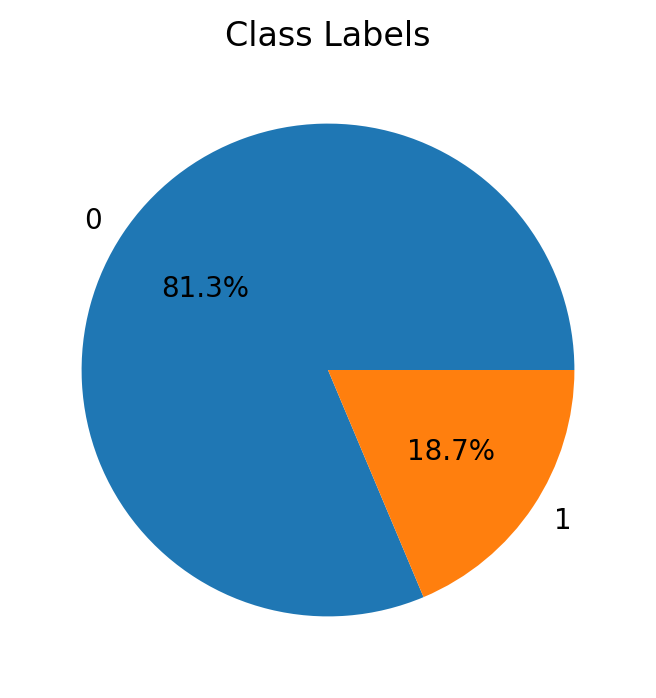

In [8]:
dist = train['Class'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(dist, labels=[0,1], autopct='%1.1f%%')
plt.title('Class Labels')
plt.show()

#### Downsampling

In [9]:
# Separate majority and minority classes
majority_class = train[train['Class'] == 0]
minority_class = train[train['Class'] == 1]

# Downsample the majority class to match the size of the minority class
downsampled_majority = resample(majority_class,
                                replace=False,     # Without replacement
                                n_samples=len(minority_class),  # Match minority class size
                                random_state=42)   # For reproducibility

# Combine the downsampled majority class with the minority class
train = pd.concat([downsampled_majority, minority_class])

# Shuffle the data to avoid any order bias
train = train.sample(frac=1, random_state=42)

### Missing Data

In [10]:
train_summary = train.describe().transpose()
train_summary.head()

,count,mean,std,min,25%,50%,75%,max
AB,184.0,0.602981,0.675666,0.098279,0.282018,0.418754,0.682078,6.161666
AF,184.0,4116.521055,2962.048518,192.593280,2495.266840,3730.342880,4979.977035,28688.187660
AH,184.0,118.145892,113.515872,85.200147,85.200147,85.200147,106.413094,1237.940805
AM,184.0,57.355741,109.194252,5.562212,14.261685,24.212346,44.788814,630.518230
AR,184.0,10.206833,5.781580,8.138688,8.138688,8.138688,8.138688,50.253252


We have 9 columns with missing data, as can be seen below. The columns with the most missing data are BQ and EL, each with 60 null values. Since 60 null values amounts to only about 10% of the dataset, it is reasonable to use imputation to fill the missing values.

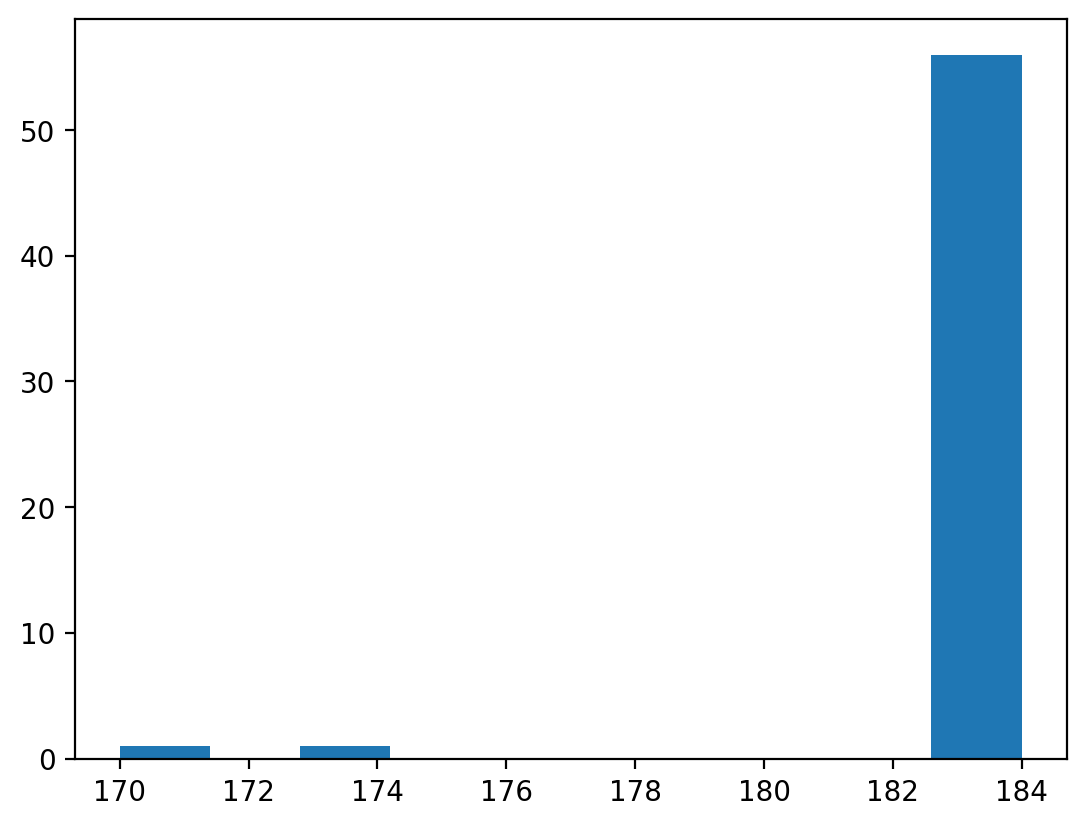

Summary of Columns with Missing Data:


,count,mean,std,min,25%,50%,75%,max
BQ,174.0,126.815540,106.279928,2.370550,37.551075,104.263823,165.905286,344.644105
EL,170.0,73.191329,38.657180,11.072919,33.735702,90.214088,109.125159,109.125159


In [11]:
plt.hist(train_summary['count'])
plt.show()
print("Summary of Columns with Missing Data:")
train_summary.loc[train_summary['count'] < 182]

Start with simple imputation which will fill missing values with the mean of the other values recorded for that feature. Note that iterative imputation is also possible through sk learn: https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer

In [12]:
# Identify continuous variables (assuming they are numeric)
continuous_vars = train.select_dtypes(include='number').columns

# Perform mean imputation for continuous variables
train[continuous_vars] = train[continuous_vars].fillna(train[continuous_vars].mean())


In [13]:
# Check which columns still have missing values 
sum_null = train.isnull().sum()
sum_null[sum_null!=0]

Series([], dtype: int64)

### Split Training Set into X and Y

In [14]:
columns = train.columns.drop(['Id','Class'])
columns

Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR',
       'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'EJ_A', 'EJ_B'],
      dtype='object')

In [15]:
# save x_train, y_train, X_test and Y_test as Numpy arrays
y_train = train['Class'].values
y_test = test['Class'].values

X_train = train[columns].values
X_test = test[columns].values


# # Check the shape of the train and test sets
print('Shape X_train: ', X_train.shape, '\nShape X_test: ', X_test.shape,
      '\nShape y_train: ', y_train.shape, '\nShape y_test:', y_test.shape)
    
# print('Shape X_train: ', X_train.shape,
#       '\nShape y_train: ', y_train.shape)

Shape X_train:  (184, 57) 
Shape X_test:  (124, 57) 
Shape y_train:  (184,) 
Shape y_test: (124,)


In [16]:
X_train

array([[2.22196000e-01, 1.72037921e+03, 8.52001470e+01, ...,
        2.19780000e+01, 1.00000000e+00, 0.00000000e+00],
       [1.62374000e-01, 3.30114620e+03, 8.52001470e+01, ...,
        1.60380000e+01, 0.00000000e+00, 1.00000000e+00],
       [2.52107000e-01, 6.38261448e+03, 4.10629350e+02, ...,
        1.71564033e-01, 0.00000000e+00, 1.00000000e+00],
       ...,
       [7.05045000e-01, 4.17851962e+03, 8.52001470e+01, ...,
        2.19780000e+01, 1.00000000e+00, 0.00000000e+00],
       [2.35015000e-01, 1.60860062e+03, 1.22518212e+02, ...,
        6.97086030e-02, 0.00000000e+00, 1.00000000e+00],
       [4.43537400e+00, 4.84361790e+03, 1.23794080e+03, ...,
        2.19780000e+01, 1.00000000e+00, 0.00000000e+00]])

### Standardize values between 0 and 1

In [17]:
#normalize all values to be between 0 and 1
X_train = (X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train))

#view normalized array
print(X_train)

[[1.23958542e-06 9.59763896e-03 4.75313957e-04 ... 1.22610706e-04
  5.57879269e-06 0.00000000e+00]
 [9.05850884e-07 1.84164103e-02 4.75313957e-04 ... 8.94726771e-05
  0.00000000e+00 5.57879269e-06]
 [1.40645269e-06 3.56072830e-02 2.29081601e-03 ... 9.57120173e-07
  0.00000000e+00 5.57879269e-06]
 ...
 [3.93329989e-06 2.33110947e-02 4.75313957e-04 ... 1.22610706e-04
  5.57879269e-06 0.00000000e+00]
 [1.31109996e-06 8.97404937e-03 6.83503705e-04 ... 3.88889845e-07
  0.00000000e+00 5.57879269e-06]
 [2.47440320e-05 2.70215401e-02 6.90621511e-03 ... 1.22610706e-04
  5.57879269e-06 0.00000000e+00]]


# 4. Model Building

## First Attempt: Basic Perceptron


Most basic perceptron option:

In [18]:
class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1234):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

Train the perceptron:

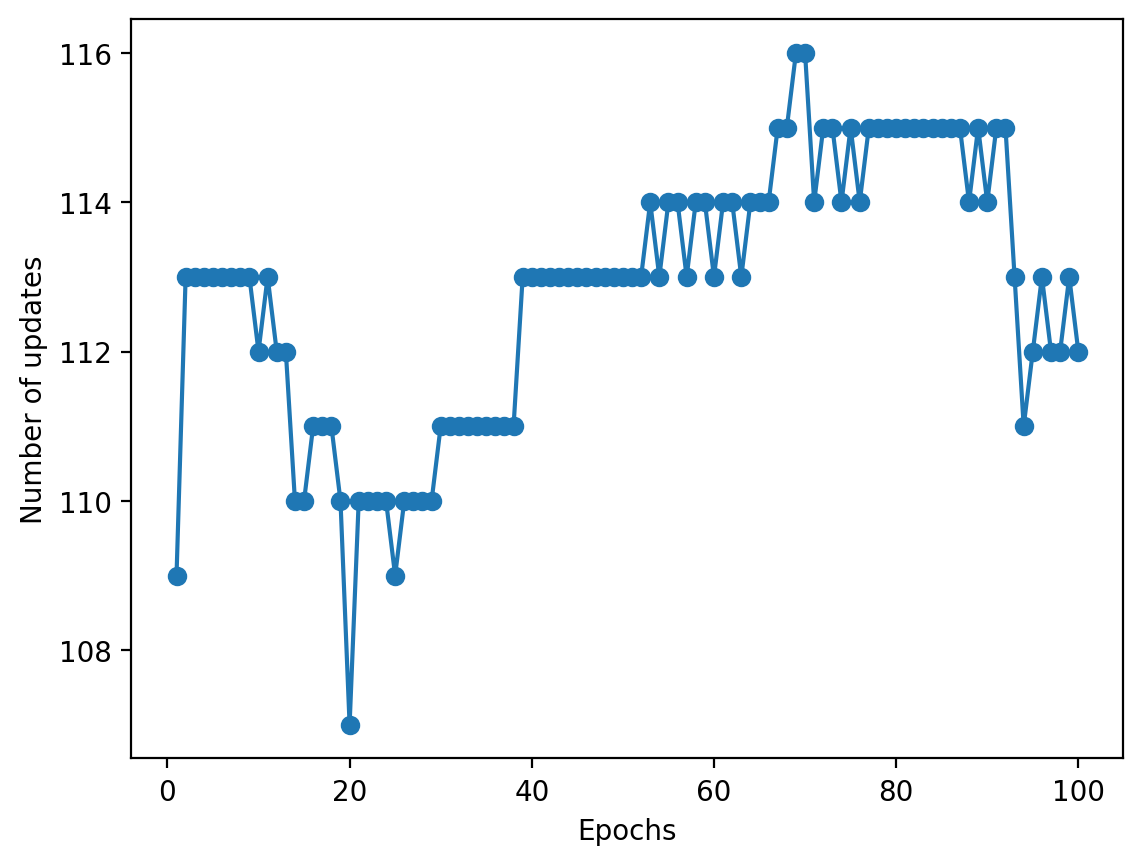

In [19]:
ppn = Perceptron(eta=0.0001, n_iter=100)

ppn.fit(X_train, y_train)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')

# plt.savefig('images/02_07.png', dpi=300)
plt.show()

Based on the massive error rate, it seems the model isn't converging and therefore the data is not perfectly linearly separable. We can reduce the number of features in the model to try to achieve linear separability.

Based on Juliana's analysis using Random Forest, we will focus on the following features, in order of importance: 

**Suggested features for input:** DU, AB, BQ, GL, CR, DA, DI, AF, CC, EE, FR, DE, EB, DL, CD, FE, DH, BC, FI, EU, BN, BP, CU, CB, DY, FC, DN, AM, EG, CS, GH, CF, GF, BD, GI


#### Model with Specified Input Features

In [20]:
#create a new array with selected features
feature_list = ['DU', 'BQ']
columns = list(columns)
X_limited_train = np.array([])

for feature in feature_list:
    feature_index = columns.index(feature)
    feature_array = X_train[:, feature_index]
    
    if X_limited_train.size == 0:
        X_limited_train = feature_array
    else:
        X_limited_train = np.column_stack((X_limited_train, feature_array))

In [21]:
X_limited_train.shape

(184, 2)

Train new perceptron with fewer features.

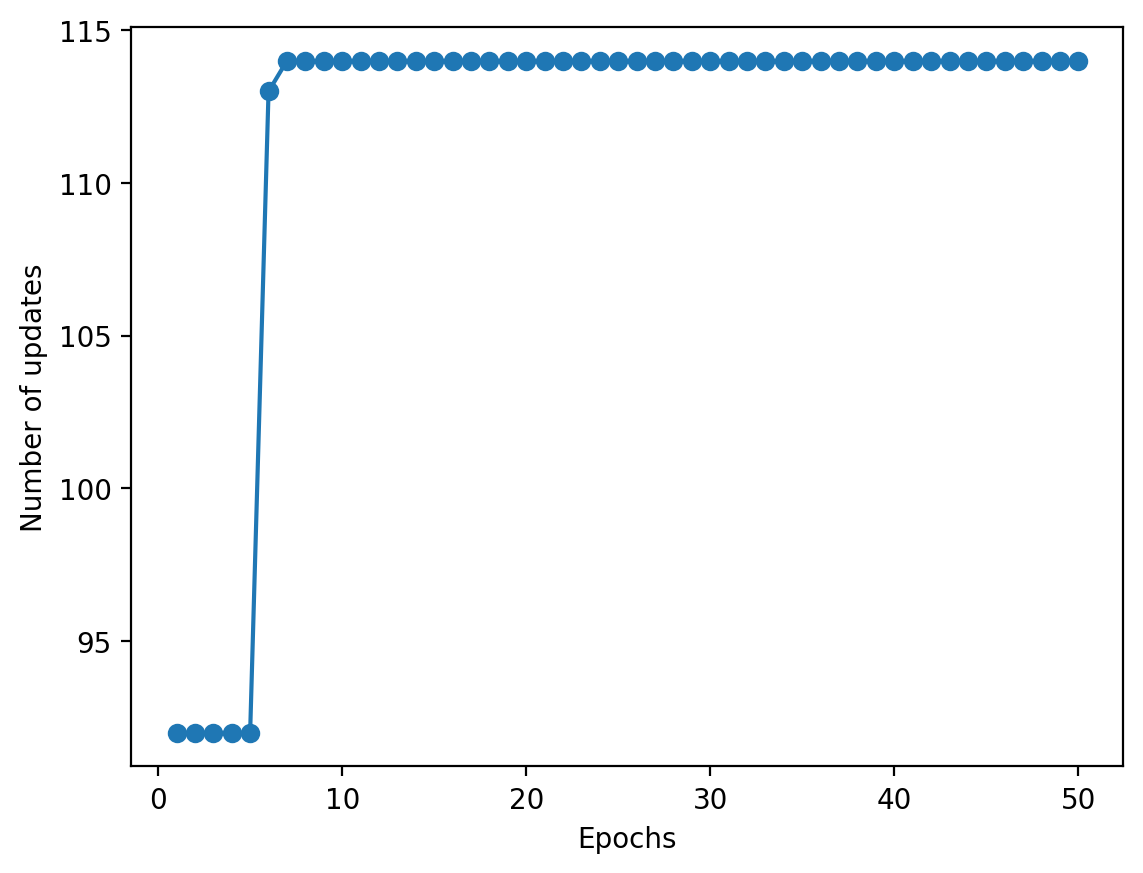

In [22]:
ppn = Perceptron(eta=0.00001, n_iter=50)

ppn.fit(X_limited_train, y_train)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')

# plt.savefig('images/02_07.png', dpi=300)
plt.show()

This also doesn't converge. As we can see DU and BQ are not linearly separable.

### <font color='red'>Need to add legend and title to this plot </font> 

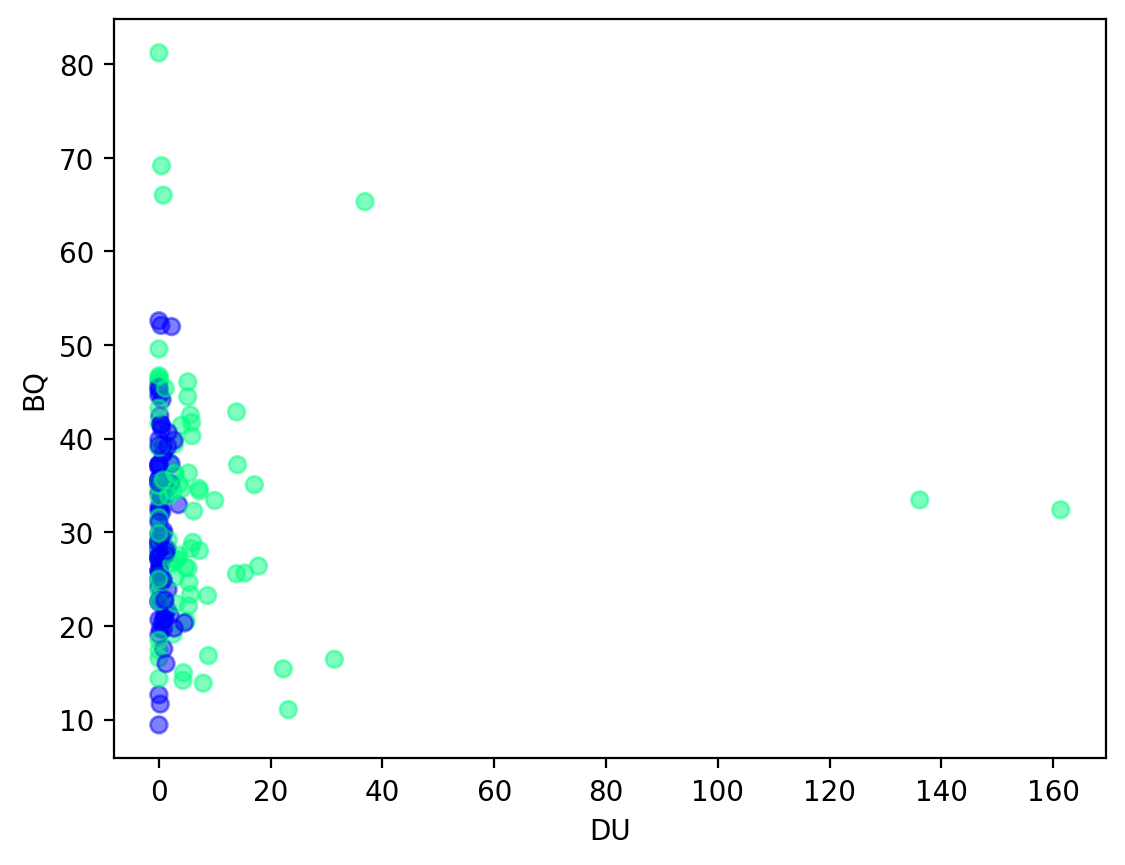

In [53]:
#plot DU vs. BQ
colormap = 'cividis'
plt.scatter(train['DU'], train['GH'],alpha = 0.5, c=y_train, cmap = 'winter')
plt.ylabel('BQ')
plt.xlabel('DU')
plt.show()

### Logistic Regression

An alternative, more flexible option is to use logistic regression, creating an architecutre with a single dense layer and a sigmoid activation function. Logistic regression is very similar to a perceptron but allows us to predict probabilities of binary outcomes as opposed to just a -1 / 1 outcome.

In [24]:
def perceptron_tfmodel(num_features, activation = 'sigmoid', learning_rate = 0.001, optimizer = 'SGD'):
    
    #clear session and set random seed for consistent behavior
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    
    #Build model using Keras Sequential API
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(1, activation = activation, input_shape = (num_features,))
    ])
    
    #set up optimizer
    sgd_optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate)
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    if optimizer == 'Adam':
        optimizer = adam_optimizer
    else:
        optimizer = sgd_optimizer
    
    #compile model
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
                  metrics=[tf.keras.metrics.AUC()])
    
    return model

Start with a limited number of parameters. **Suggested features for input:** DU, AB, BQ, GL, CR, DA, DI, AF, CC, EE, FR, DE, EB, DL, CD, FE, DH, BC, FI, EU, BN, BP, CU, CB, DY, FC, DN, AM, EG, CS, GH, CF, GF, BD, GI

In [25]:
#create a new array with selected features

#um.... is CD not in the list?? 
feature_list = ['DU', 'AB','BQ','GL','CR','DA','DI','AF','CC','EE','FR',
                'DE','EB','DL','CD ','FE','DH','BC','FI','EU','BN', 'BP',
                'CU', 'CB', 'DY', 'FC', 'DN', 'AM','EG','CS','GH','CF','GF',
                'BD ','GI']
columns = list(columns)
X_limited_train = np.array([])

for feature in feature_list:
    feature_index = columns.index(feature)
    feature_array = X_train[:, feature_index]
    
    if X_limited_train.size == 0:
        X_limited_train = feature_array
    else:
        X_limited_train = np.column_stack((X_limited_train, feature_array))

In [26]:
X_limited_train.shape

(184, 35)

In [27]:
model = perceptron_tfmodel(num_features = X_limited_train.shape[1], learning_rate = 0.5)

Metal device set to: Apple M2


2023-08-07 18:48:11.623069: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-07 18:48:11.623149: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [28]:
#Fit the model
tf.random.set_seed(1234)
np.random.seed(1234)
# Train model
hist= model.fit(x=X_limited_train,
                y=y_train,
                validation_split=0.1, # set 20% of train data for validation
                batch_size= 15, #choose smaller batch size bc we're guessing there are local optima 
                epochs=50,
                verbose=1 #silence fit
)

Epoch 1/50


2023-08-07 18:48:11.976956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 1s 30ms/step - loss: 0.6904 - auc: 0.5524 - val_loss: 0.6950 - val_auc: 0.6071
Epoch 2/50
10/11 [==========================>...] - ETA: 0s - loss: 0.6897 - auc: 0.5525

2023-08-07 18:48:12.379223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 0s 10ms/step - loss: 0.6902 - auc: 0.5608 - val_loss: 0.6964 - val_auc: 0.6369
Epoch 3/50
11/11 [==============================] - 0s 9ms/step - loss: 0.6884 - auc: 0.6102 - val_loss: 0.6913 - val_auc: 0.6964
Epoch 4/50
11/11 [==============================] - 0s 9ms/step - loss: 0.6864 - auc: 0.6349 - val_loss: 0.6924 - val_auc: 0.6488
Epoch 5/50
11/11 [==============================] - 0s 9ms/step - loss: 0.6865 - auc: 0.5918 - val_loss: 0.7002 - val_auc: 0.6726
Epoch 6/50
11/11 [==============================] - 0s 9ms/step - loss: 0.6853 - auc: 0.5841 - val_loss: 0.7160 - val_auc: 0.6667
Epoch 7/50
11/11 [==============================] - 0s 10ms/step - loss: 0.6870 - auc: 0.5940 - val_loss: 0.7186 - val_auc: 0.6726
Epoch 8/50
11/11 [==============================] - 0s 10ms/step - loss: 0.6854 - auc: 0.5906 - val_loss: 0.7037 - val_auc: 0.6488
Epoch 9/50
11/11 [==============================] - 0s 9ms/step - loss: 0.6854 - auc: 0.6183 - val

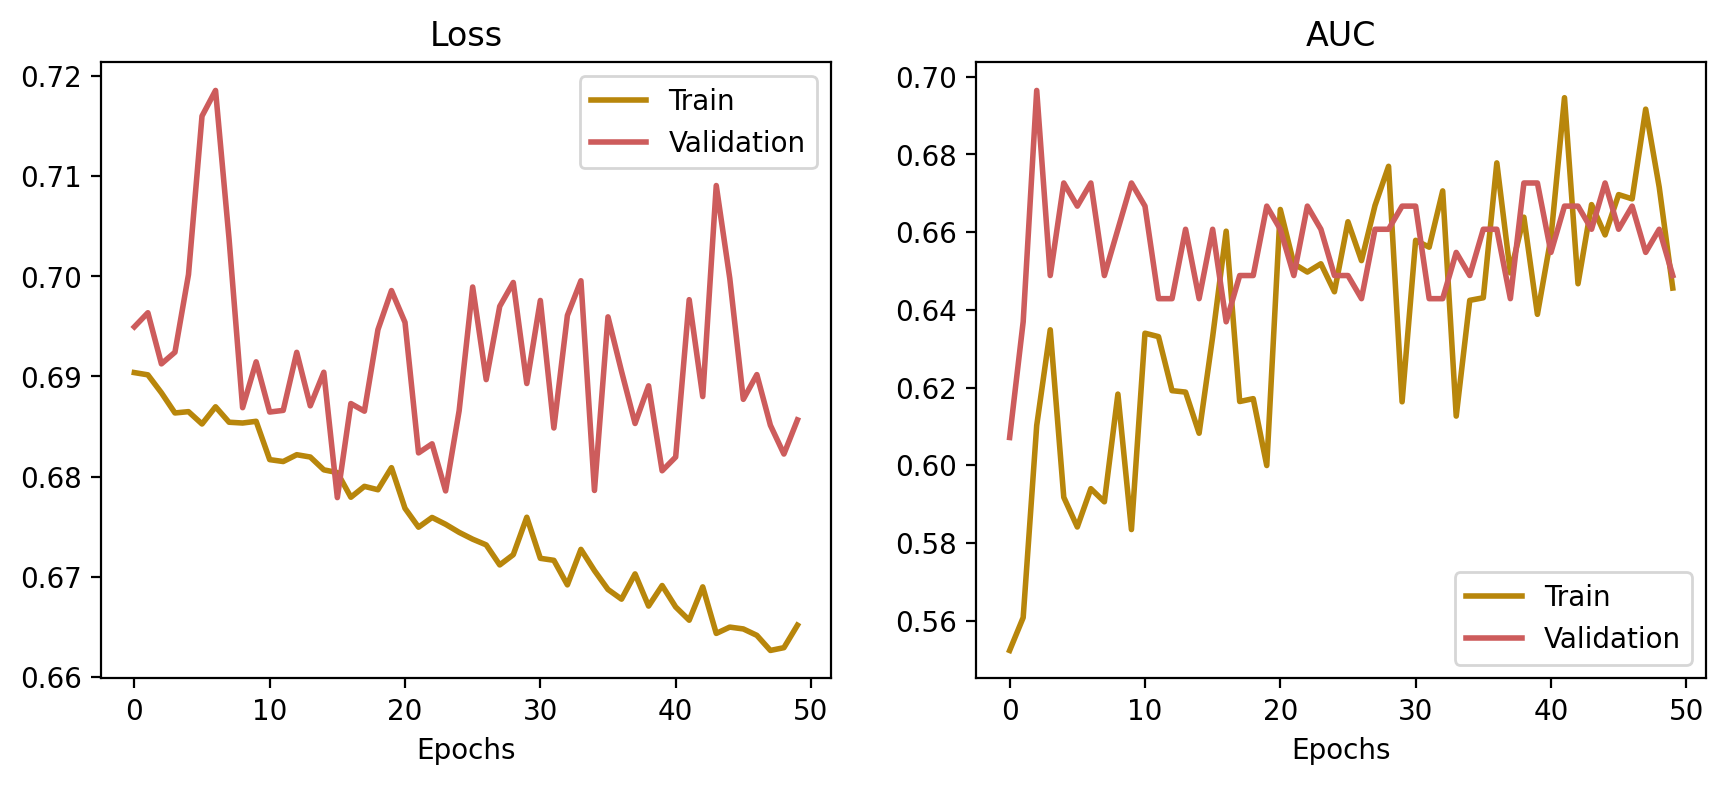

In [29]:
# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history['auc'], lw=2, color='darkgoldenrod')
plt.plot(history['val_auc'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('AUC');

**Conclusion:** Logistic regression is better performing than a basic perceptron, but is still not close to great performance. A perceptron will not converge as the data is not linearly separable.